In [1]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import glob

# Import dependencies
from scipy.io import wavfile
from sklearn.svm import SVC
from scipy.signal import spectrogram
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

import glob,os,time
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.INFO)


In [4]:
!ls /gdrive/My\ Drive/Colab\ Notebooks/Projects

heartbeat


In [0]:
dataset1 = [{'path': path, 'label': "normal"} for path in glob.glob("/gdrive/My Drive/Colab Notebooks/Projects/heartbeat/Btraining_normal/*.wav")]

In [0]:
dataset2 = [{'path': path, 'label': "normal"} for path in glob.glob("/gdrive/My Drive/Colab Notebooks/Projects/heartbeat/Atraining_normal/*.wav")]

In [0]:
dataset3 = [{'path': path, 'label': "murmur"} for path in glob.glob("/gdrive/My Drive/Colab Notebooks/Projects/heartbeat/Btraining_murmur/*.wav")]


In [0]:
dataset4 = [{'path': path, 'label': "murmur"} for path in glob.glob("/gdrive/My Drive/Colab Notebooks/Projects/heartbeat/Btraining_murmur/*.wav")]


In [0]:
dataset5 = [{'path': path, 'label': "extrastole"} for path in glob.glob("/gdrive/My Drive/Colab Notebooks/Projects/heartbeat/Btraining_extrastole/*.wav")]


In [0]:
df1 = pd.DataFrame.from_dict(dataset1)

In [0]:
df3 = pd.DataFrame.from_dict(dataset3)

In [0]:
df5 = pd.DataFrame.from_dict(dataset5)
df2 = pd.DataFrame.from_dict(dataset2)
df4 = pd.DataFrame.from_dict(dataset4)
frames=[df1,df3,df4,df5,df2]
df=pd.concat(frames)


In [0]:


df['x'] = df['path'].apply(lambda x: wavfile.read(x)[1])
df.head()

In [0]:
# Collect one sample from each of the three classes and plot their waveforms
normal = df[df['label'] == 'normal' ].sample(1)
extrasystole = df[df['label'] == 'extrastole' ].sample(1)

# Plot the three samples onto three different figures
plt.figure(1, figsize=(10,5))
plt.title('normal')
plt.plot(normal['x'].values[0], c='m')



plt.figure(2, figsize=(10, 5))
plt.title('extrasystole')
plt.plot(extrasystole['x'].values[0], c='b')

In [0]:
max_length = max(df['x'].apply(len))

# Kaggle: What's in a heartbeat? - Peter Grenholm
def repeat_to_length(arr, length):
    """Repeats the numpy 1D array to given length, and makes datatype float"""
    result = np.empty((length, ), dtype = np.float32)
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

df['x'] = df['x'].apply(repeat_to_length, length=max_length)
df.head()

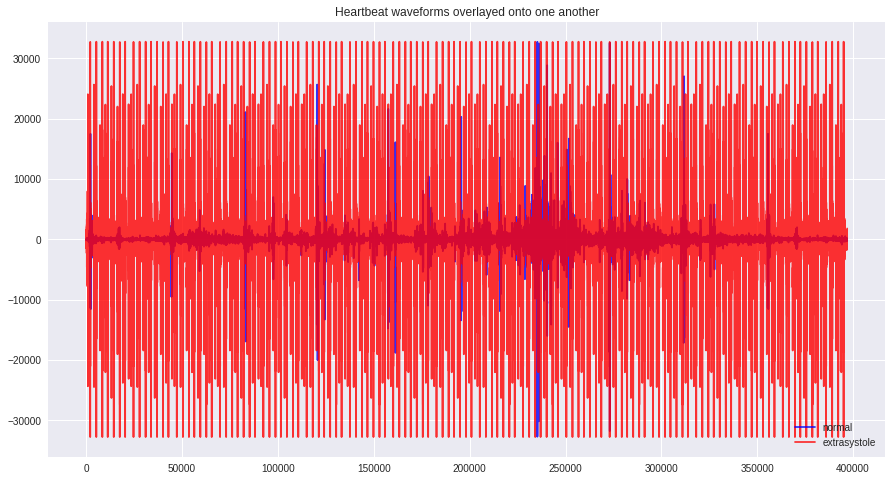

In [14]:
normal = df[df['label'] == 'normal' ].sample(1)
extrasystole = df[df['label'] == 'extrastole' ].sample(1)

plt.figure(1, figsize=(15,8))
plt.plot(normal['x'].values[0], c='b', label='normal', alpha=0.8)
plt.plot(extrasystole['x'].values[0], c='r', label='extrasystole', alpha=0.8)

plt.title('Heartbeat waveforms overlayed onto one another')
plt.legend(loc='lower right')
# plt.savefig('temp.png')

Text(0.5, 0, 'Time [sec]')

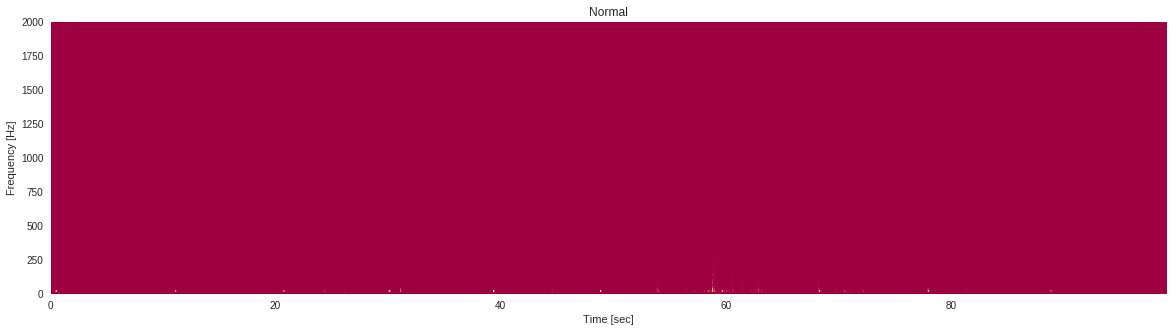

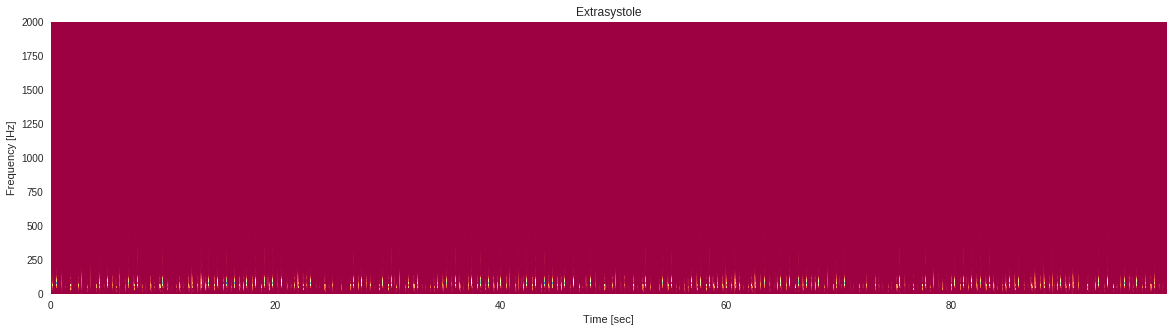

In [15]:
fs = 4000
f_normal, t_normal, Sxx_normal = spectrogram(normal['x'].values[0], 4000)
plt.figure(1, figsize=(20,5))
plt.title('Normal')
plt.pcolormesh(t_normal, f_normal, Sxx_normal, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')



f_extra, t_extra, Sxx_extra = spectrogram(extrasystole['x'].values[0], 4000)
plt.figure(2, figsize=(20, 5))
plt.title('Extrasystole')
plt.pcolormesh(t_extra, f_extra, Sxx_extra, cmap='Spectral')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [16]:
df.describe()

,label,path,x
count,77,77,77
unique,2,77,77
top,extrastole,/gdrive/My Drive/Colab Notebooks/Projects/hear...,"[14.0, 17.0, 14.0, 0.0, 2.0, 11.0, -2.0, 5.0, ..."
freq,46,1,1


In [17]:
df['label'].unique()

array(['extrastole', 'normal'], dtype=object)

In [0]:

x = np.stack(df['x'].values, axis=0)
y = np.stack(df['label'].values, axis=0)

In [19]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test, train_filenames, test_filenames = train_test_split(x, df['label'].values, df['path'].values, test_size=0.25)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))

x_train: (57, 396900), x_test: (20, 396900)


In [20]:
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]
x_train.shape

(57, 396900, 1)

In [0]:
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [22]:
import keras.backend as K
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

Using TensorFlow backend.


In [0]:
from keras.layers import LSTM
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.layers import InputLayer, Conv1D, Dense, Flatten, MaxPool1D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from keras import metrics
import tensorflow as tf
from sklearn.model_selection import  train_test_split
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(tf.keras.layers.MaxPool1D(strides=4))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.75))
model.add(tf.keras.layers.GlobalAvgPool1D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

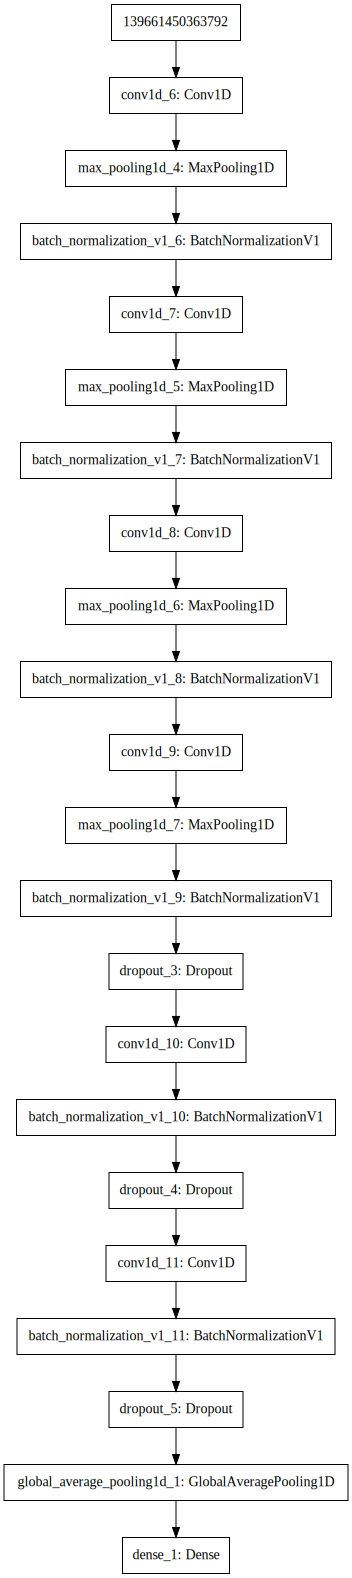

In [41]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
def batch_generator(x_train, y_train, batch_size):
    """
    Rotates the time series randomly in time
    """
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    full_idx = range(x_train.shape[0])
    
    while True:
        batch_idx = np.random.choice(full_idx, batch_size)
        x_batch = x_train[batch_idx]
        y_batch = y_train[batch_idx]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In [0]:
weight_saver = ModelCheckpoint('set_a_weights.h5', monitor='val_loss', 
                               save_best_only=True, save_weights_only=True)

In [0]:
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [0]:
import keras.backend as K
def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(1e-4), loss='categorical_crossentropy', metrics=['accuracy',recall,metrics.categorical_accuracy,'mae',mean_pred])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

In [29]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                 epochs=30,
                 validation_data=(x_test, y_test_hot),verbose=2)

y_train_class_names: ['normal' 'extrastole']
y_test_class_names: ['normal' 'extrastole']
Train on 57 samples, validate on 20 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 4s - loss: 1.6972 - acc: 0.2105 - recall: 0.2050 - categorical_accuracy: 0.2105 - mean_absolute_error: 0.5860 - mean_pred: 0.5000 - val_loss: 1.7768 - val_acc: 0.2000 - val_recall: 0.2000 - val_categorical_accuracy: 0.2000 - val_mean_absolute_error: 0.6065 - val_mean_pred: 0.5000
Epoch 2/30
 - 1s - loss: 1.6470 - acc: 0.1930 - recall: 0.1981 - categorical_accuracy: 0.1930 - mean_absolute_error: 0.5715 - mean_pred: 0.5000 - val_loss: 1.6398 - val_acc: 0.2000 - val_recall: 0.2000 - val_categorical_accuracy: 0.2000 - val_mean_absolute_error: 0.5674 - val_mean_pred: 0.5000
Epoch 3/30
 - 1s - loss: 1.6272 - acc: 0.2105 - recall: 0.2050 - categorical_accuracy: 0.2105 - mean_absolute_error: 0.5625 - mean_pred: 0.5000 - val_loss: 1.5767 - val_acc: 0.1500 - val_recall: 0.1500 - val_categorical_accuracy:

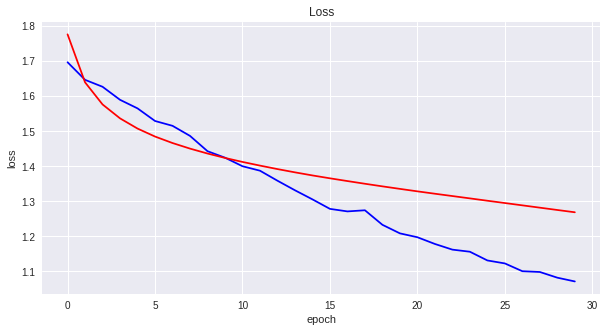

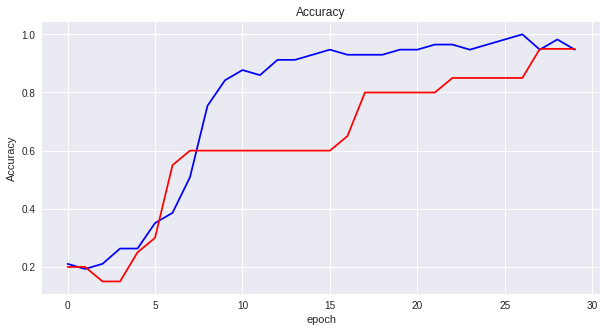

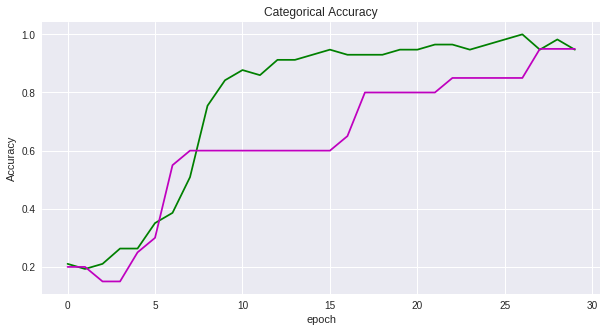

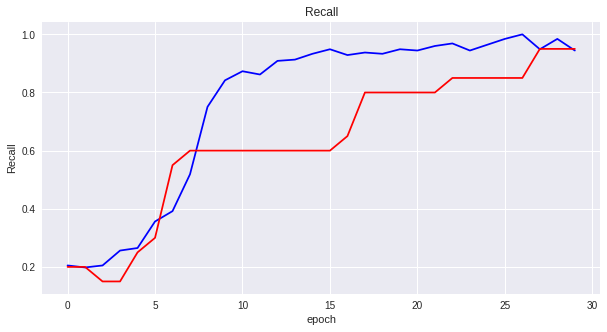

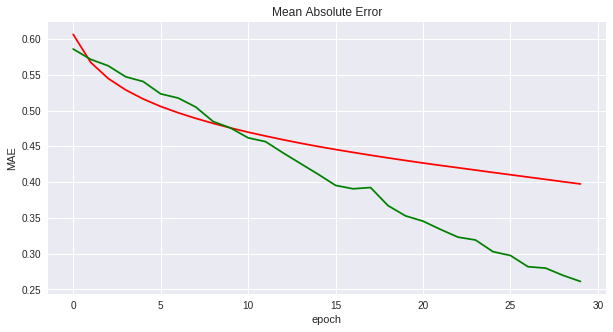

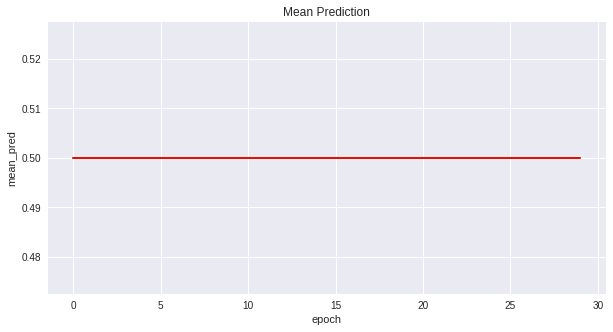

In [30]:
plt.figure(1, figsize=(10, 5))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('Loss')
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()

plt.figure(2, figsize=(10, 5))
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Accuracy')
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

plt.figure(6, figsize=(10, 5))
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title('Categorical Accuracy')
plt.plot(hist.history['categorical_accuracy'], color='g')
plt.plot(hist.history['val_categorical_accuracy'], color='m')
plt.show()

plt.figure(3, figsize=(10, 5))
plt.ylabel('Recall')
plt.xlabel('epoch')
plt.title('Recall')
plt.plot(hist.history['recall'], color='b')
plt.plot(hist.history['val_recall'], color='r')
plt.show()

plt.figure(4, figsize=(10, 5))
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.title('Mean Absolute Error')
plt.plot(hist.history['val_mean_absolute_error'], color='r')
plt.plot(hist.history['mean_absolute_error'], color='g')
plt.show()

plt.figure(5, figsize=(10, 5))
plt.ylabel('mean_pred')
plt.xlabel('epoch')
plt.title('Mean Prediction')
plt.plot(hist.history['mean_pred'], color='g')
plt.plot(hist.history['val_mean_pred'], color='r')
plt.show()

In [0]:
from keras.layers import LSTM
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import  train_test_split
x_rnn_train  = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_rnn_test  = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
from keras import metrics

In [0]:
model_name = 'Basic_LSTM'
tb = TensorBoard(log_dir='./log/{}'.format(model_name), histogram_freq=0,  
          write_graph=True, write_images=True)
callbacks = [EarlyStopping(monitor='val_loss', min_delta= 0.005, patience=20),
            EarlyStopping(monitor='val_acc', min_delta= 0.005, patience=20),tb]



model = Sequential()
model.add(LSTM(100 , input_shape=(x_rnn_train.shape[2], x_rnn_train.shape[1])))
model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc',recall,metrics.categorical_accuracy,'mae',mean_pred])

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                2550      
_________________________________________________________________
activation_8 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
__________

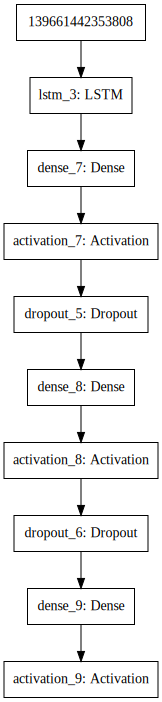

In [44]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [0]:
# Need to convert y labels into one-hot encoded vectors
y_train_int_categories, y_train_class_names = pd.factorize(y_train)
print("y_train_class_names: {0}".format(y_train_class_names))

y_test_int_categories, y_test_class_names = pd.factorize(y_test)
print("y_test_class_names: {0}".format(y_test_class_names))
y_train_hot = tf.keras.utils.to_categorical(y_train_int_categories)
y_test_hot = tf.keras.utils.to_categorical(y_test_int_categories)

hist = model.fit(x_train, y_train_hot, 
                 epochs=60,
                 validation_data=(x_test, y_test_hot),verbose=2)

y_train_class_names: ['normal' 'extrastole']
y_test_class_names: ['normal' 'extrastole']
Train on 57 samples, validate on 20 samples
Epoch 1/60


In [2]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.signal import decimate
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPool1D, GlobalAvgPool1D, Dropout, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                input_shape = x_train.shape[1:],
                kernel_regularizer = l2(0.025)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=4, kernel_size=9, activation='relu',
                kernel_regularizer = l2(0.05)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=9, activation='relu',
                 kernel_regularizer = l2(0.1)))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=9, activation='relu'))
model.add(MaxPool1D(strides=4))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.75))
model.add(GlobalAvgPool1D())
model.add(Dense(3, activation='softmax'))

Using TensorFlow backend.


NameError: ignored